In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
import itertools, time
from numpy.polynomial.chebyshev import chebvander
from numpy.polynomial.laguerre import lagvander
from scipy.stats import norm
from numpy.polynomial.hermite import hermvander
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
sns.set(style="whitegrid", palette="muted", font_scale=1.2)


# N-dimensions

In [2]:
def simulate_gbm_nd(S0, sigma, R, r, T, N_steps, N_paths, seed=None):
    """
    Simulate n-dimensional correlated GBM under the risk-neutral measure
    using antithetic variates.

    Args:
        S0: initial prices, array-like of shape (n,)
        sigma: volatilities, array-like of shape (n,)
        R: correlation matrix, shape (n, n)
        r: risk-free rate
        T: time to maturity
        N_steps: number of time steps
        N_paths: total number of simulation paths (must be even)
        seed: optional random seed

    Returns:
        paths: ndarray of shape (N_paths, N_steps+1, n)
    """
    S0 = np.array(S0, dtype=float)
    sigma = np.array(sigma, dtype=float)
    n = len(S0)

    if seed is not None:
        np.random.seed(seed)
    assert N_paths % 2 == 0, "N_paths must be even for antithetic sampling"

    dt = T / N_steps
    L = np.linalg.cholesky(R)

    paths = np.zeros((N_paths, N_steps+1, n))
    paths[:, 0, :] = S0

    half = N_paths // 2
    drift = (r - 0.5 * sigma**2) * dt

    for t in range(1, N_steps+1):
        Z_small = np.random.normal(size=(half, n))
        Z = np.vstack([Z_small, -Z_small])
        dW = Z @ L.T * np.sqrt(dt)
        diffusion = sigma * dW
        paths[:, t, :] = paths[:, t-1, :] * np.exp(drift + diffusion)

    return paths


def lsm_price_nd(paths, K, r, w, basis_functions, dt, is_call=False):
    """
    Price an American-style option on a weighted sum via the Longstaff - Schwartz method,
    but perform all regressions on the normalized state S/K.
    """
    N_paths, N_steps_plus1, _ = paths.shape
    discount = np.exp(-r * dt)
    w = np.array(w)
    sign = 1 if is_call else -1

    # Value‐matrix: rows=paths, cols=time‐steps
    V = np.zeros((N_paths, N_steps_plus1))
    V[:, -1] = np.maximum(sign * (paths[:, -1, :] @ w - K), 0)

    # Backward induction over all intermediate exercise dates
    for t in range(N_steps_plus1 - 2, 0, -1):
        S_t    = paths[:, t, :]
        payoff = np.maximum(sign * (S_t @ w - K), 0)
        itm    = payoff > 0
        cont   = discount * V[:, t + 1]

        # Non‐ITM simply continuation
        V[~itm, t] = cont[~itm]

        if np.any(itm):
            # 1) extract the raw in‐the‐money sub‐paths
            S_itm = S_t[itm]                     # shape = (N_itm, n)

            # 2) **normalize** by strike
            S_itm_scaled = S_itm / K             # dimensionless input

            # 3) build the regression matrix on S/K
            B = np.vstack([f(S_itm_scaled) for f in basis_functions]).T

            X       = B
            Y       = cont[itm]
            model   = LinearRegression().fit(X, Y)
            cont_fit = model.predict(X)

            # Decide exercise versus continuation
            exercise     = payoff[itm] > cont_fit
            V[itm, t]    = np.where(exercise, payoff[itm], cont[itm])

    # At t=0, compare immediate exercise to continuation
    payoff0 = np.maximum(sign * (paths[:, 0, :] @ w - K), 0)
    cont0   = discount * V[:, 1]
    V0      = np.where(payoff0 > cont0, payoff0, cont0)

    price  = V0.mean()
    stderr = V0.std(ddof=1) / np.sqrt(N_paths)
    return float(price), float(stderr)


def scale_to_unit(x):
    """
    Scale array x to [-1, 1] using its own min and max.
    """
    x = np.asarray(x, dtype=float)
    a, b = x.min(), x.max()
    if b == a:
        return np.zeros_like(x)
    return 2 * (x - a) / (b - a) - 1

def chebyshev_basis_nd(n, degree):
    indices = list(itertools.product(range(degree+1), repeat=n))
    def make_fn(alpha):
        def fn(S):
            feat = None
            for j, power in enumerate(alpha):
                xj = scale_to_unit(S[:, j])
                Tj = chebvander(xj, degree)[:, power]
                feat = Tj if feat is None else feat * Tj
            return feat
        return fn
    return [make_fn(alpha) for alpha in indices]

def laguerre_basis_nd(n, degree):
    indices = list(itertools.product(range(degree+1), repeat=n))
    def make_fn(alpha):
        def fn(S):
            mats = [lagvander(S[:, j], degree)[:, alpha[j]] for j in range(n)]
            feat = mats[0]
            for mat in mats[1:]:
                feat = feat * mat
            return feat
        return fn
    return [make_fn(alpha) for alpha in indices]

def hermite_basis_nd(n, degree):
    indices = list(itertools.product(range(degree+1), repeat=n))
    def make_fn(alpha):
        def fn(S):
            mats = [hermvander(S[:, j], degree)[:, alpha[j]] for j in range(n)]
            feat = mats[0]
            for mat in mats[1:]:
                feat = feat * mat
            return feat
        return fn
    return [make_fn(alpha) for alpha in indices]


We were initially planning on having both sigma at 0.2 and 0.4, but since we saw no point in presenting it too, we chose to simply run with 0.2. This is the reason most of this part of the code is written inside vol_list loops. Furthermore, in order to change the number of assets to 5, simply switch the n to 5. It shall be noted, that we had to ask a friend for computer power(GPU), as our own CPU's did not have sufficient power. Therefore, all the results, will not be shown here, but the code matches. 

In [3]:
if __name__ == "__main__":
    n = 2
    S0 = [40.0]*n
    r = 0.06
    T = 1.0
    N_steps = 50
    N_paths = 100000
    K = 40.0
    w = [1/n]*n
    seed = 2025

    rho = 0.2
    R = np.full((n, n), rho)
    np.fill_diagonal(R, 1.0)

    vol_list = [0.2]
    basis_gens = {
        'Chebyshev': chebyshev_basis_nd,
        'Laguerre':  laguerre_basis_nd,
        'Hermite':   hermite_basis_nd
    }
    degree = 3

    dt = T / N_steps
    for vol in vol_list:
        sigma = [vol]*n
        paths = simulate_gbm_nd(S0, sigma, R, r, T, N_steps, N_paths, seed)

        for name, gen in basis_gens.items():
            basis = gen(n, degree)

            # Start timer
            t0 = time.perf_counter()
            price, stderr = lsm_price_nd(paths, K, r, w, basis, dt=dt, is_call=False)
            # Stop timer
            elapsed = time.perf_counter() - t0

            print(
                f"n={n}, σ={vol:.2f}, Basis={name:9s} : "
                f"Price={price:.4f} ± {stderr:.4f}   "
                f"(computed in {elapsed:.3f} s)"
            )

n=2, σ=0.20, Basis=Chebyshev : Price=1.6609 ± 0.0064   (computed in 2.716 s)
n=2, σ=0.20, Basis=Laguerre  : Price=1.6609 ± 0.0064   (computed in 2.790 s)
n=2, σ=0.20, Basis=Hermite   : Price=1.6609 ± 0.0064   (computed in 2.578 s)


# European Check
The European basket of option should yield a lower price because the time option embedded into the American should be above 0, which pushes the American price above the European. Therefore, if the price is not eqvalent or higher than the European price, we have priced it wrong. This is theory is not gone through in the assignment itself, but it is in place to compute the European check. As this is a closed formula, this could in theory be solved by pen and paper. 

In [4]:
def basket_put_price(S, K, r, sigma, rho, T, weights=None):
    """
    Calculates the price of an European basket-put under the Black-76 scheme

    Parameters:
        S       : Array of stock prices at t0 given as S_i
        K       : Strikeprice, same for all assets
        r       : Risk-free rate (annualized) 
        sigma   : Volatilities σ_i (scalar for uniform or array for individual)
        rho     : correlation matrix ρ (scalar for uniform or array for individual)
        T       : Time to maturity (in years)
        weights : weights for each asset, they are set to equal

    Returns:
        price of a put (float)
    """
    # Konverter inputs til numpy arrays
    S = np.array(S, dtype=float)
    n = len(S)

    # Weights: default to equal and normalize
    if weights is None:
        weights = np.full(n, 1.0 / n)
    else:
        weights = np.array(weights, dtype=float)
        weights = weights / np.sum(weights)

    # Volatiliteter: ensartet eller per aktiv
    if np.isscalar(sigma):
        sigma = np.full(n, sigma)
    else:
        sigma = np.array(sigma, dtype=float)

    # Korrelationsmatrix
    if np.isscalar(rho):
        corr = np.full((n, n), rho)
        np.fill_diagonal(corr, 1.0)
    else:
        corr = np.array(rho, dtype=float)
        if not np.allclose(corr, corr.T):
            raise ValueError("Correlation matrix must be symmetric")

    # Covariance Σ = D · corr · D
    D = np.diag(sigma)
    Sigma = D @ corr @ D

    # Beregn basket-forward og forward-volatilitet
    B0 = np.dot(weights, S)
    FB = B0 * np.exp(r * T)
    sigmaB2 = weights @ Sigma @ weights
    sigmaB = np.sqrt(sigmaB2)

    # Håndter degenererede tilfælde
    if sigmaB <= 0 or T <= 0:
        return max(K - B0, 0) * np.exp(-r * T)

    # Black-76 d1 og d2
    d1 = (np.log(FB / K) + 0.5 * sigmaB2 * T) / (sigmaB * np.sqrt(T))
    d2 = d1 - sigmaB * np.sqrt(T)

    # Price put under Black-76
    put_price = np.exp(-r * T) * (K * norm.cdf(-d2) - FB * norm.cdf(-d1))
    return put_price


if __name__ == "__main__":
    # Eksempelparametre
    K = 40
    r = 0.06
    rho = 0.2
    T = 1.0
    S0 = 40
    sigma_values = [0.2, 0.4]

    for sigma in sigma_values:
        print(f"Results for sigma = {sigma:.2f}:")

        # 2 aktiver
        price_2 = basket_put_price(
            S=[S0, S0],
            K=K,
            r=r,
            sigma=sigma,
            rho=rho,
            T=T
        )
        print(f" European basket-put price (2 assets): {price_2:.4f}")

        # 5 aktiver
        price_5 = basket_put_price(
            S=[S0] * 5,
            K=K,
            r=r,
            sigma=sigma,
            rho=rho,
            T=T
        )
        print(f" European basket-put price (5 assets): {price_5:.4f}\n")


Results for sigma = 0.20:
 European basket-put price (2 assets): 1.4103
 European basket-put price (5 assets): 0.9205

Results for sigma = 0.40:
 European basket-put price (2 assets): 3.7051
 European basket-put price (5 assets): 2.6594



Since the price for all the different basis functions are above the European counterpart, and is not very far from the European price. We will argue, that this price is somewhat fair for the basket

# Convergence Test

We now turn towards convergence test, here we make three difffernt test. Firstly, the $[\texttt{test\_time\_convergence}]$$. This keeps the sample size fixed, but refines the exercise grid $\Delta_t = \frac{T}{N_{\mathrm{steps}}}$ with $N_{\mathrm{steps}} \in [10,25,50,100,200]$ and computes the LSM price at each refinement. We do this as the American option price should converge as the finer grid we use. I.e. we verify that our backward-induction method is consistent and our time‐discretization error vanishes in $N$. 

Secondly, $[\texttt{test\_mc\_convergence}]$. This holds the time grid fixed at $N_{\mathrm{steps}}=50$, but increases the number of simulated paths. Since LSM is a Monte Carlo method, the statistical error should scale like $(N_{\mathrm{paths}}^{-1/2})$. Therefore, the more paths, the more stable our price should become. 

Lastly, we have $[\texttt{test\_basis\_convergence}]$. This keeps both the grid and the sample size consistent, but will vary the polynomial basis degree, $d = 1,\dots,\mathrm{max\_deg}$. Since the regression basis approximates the true continuation-value function, we should see the price stabilize once the basis is sufficiently rich, or might locate eventual overfitting. In order to have the convergence plots for the basis functions, we had to cap it at d=4. 

Can be taken one at a time, or just run the whole script at once. Does take a while.




In [5]:
basis_gens = {
        'Chebyshev': chebyshev_basis_nd,
        'Laguerre':  laguerre_basis_nd,
        'Hermite':   hermite_basis_nd
    }

In [6]:
# Parameters
n = 2
S0 = [40.0] * n
sigma = [0.2] * n
rho = 0.2
R = np.full((n, n), rho)
np.fill_diagonal(R, 1.0)
r, T, K = 0.06, 1.0, 40.0
w = [1.0/n] * n
seed = 2025

# Fine‐grid / max‐sample settings
N_steps_max = 200
N_paths_max = 200_000
dt_max = T / N_steps_max

# Simulate once at the finest grid & sample
paths_max = simulate_gbm_nd(S0, sigma, R, r, T, N_steps_max, N_paths_max, seed)


=== Convergence tests using Chebyshev basis ===


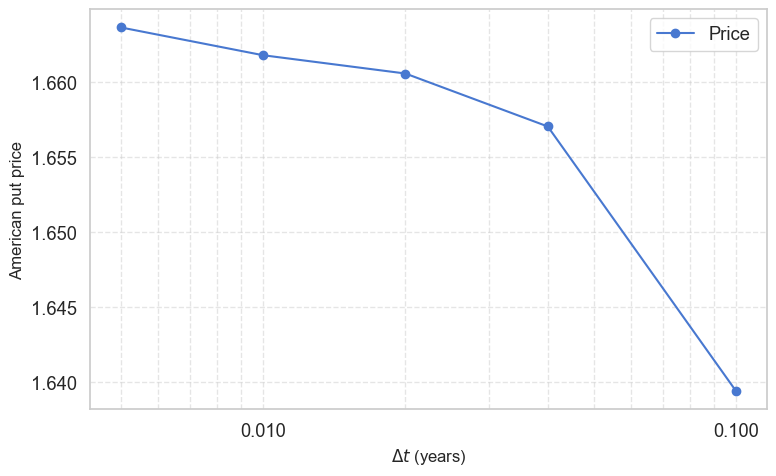

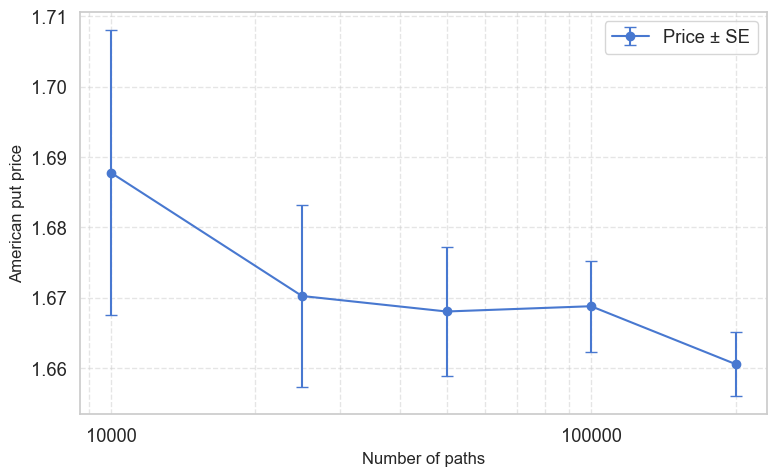

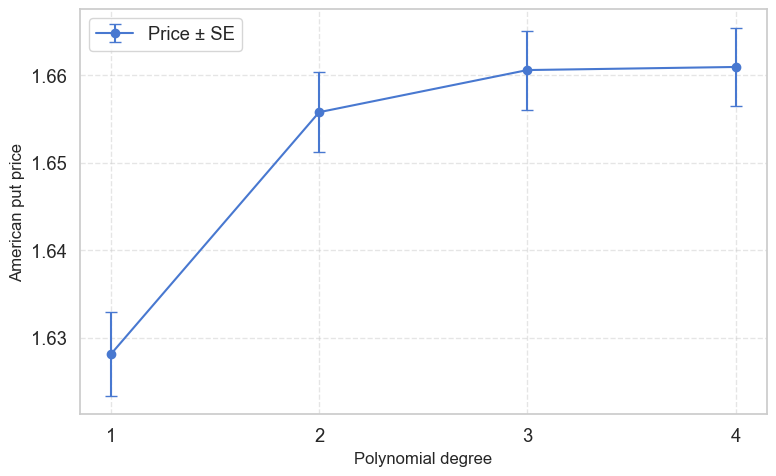


=== Convergence tests using Laguerre basis ===


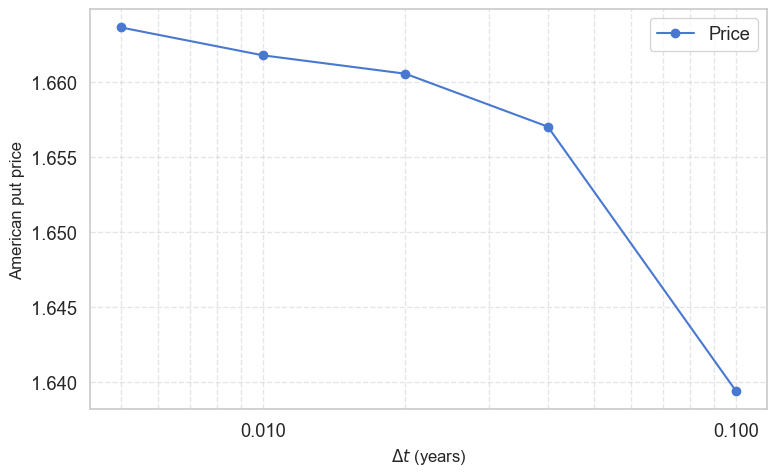

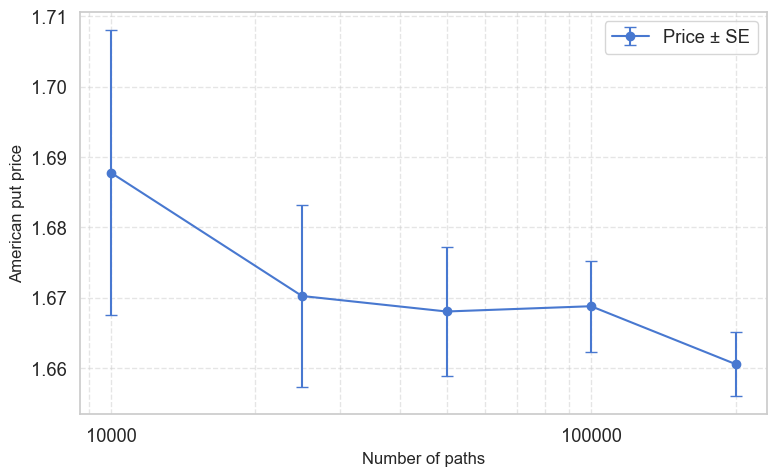

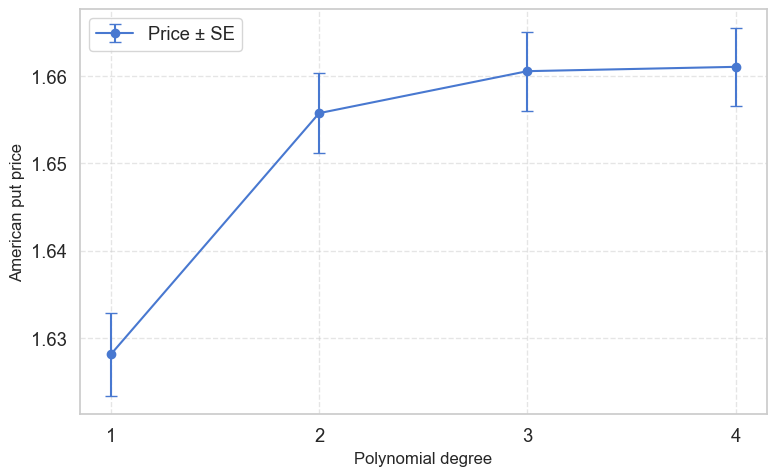


=== Convergence tests using Hermite basis ===


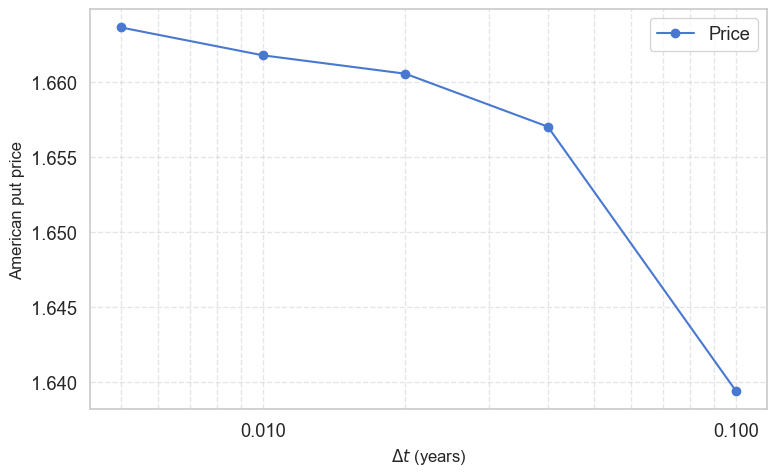

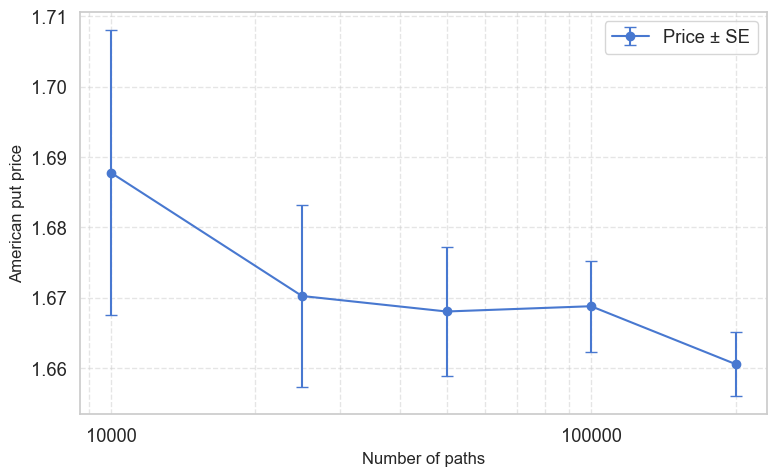

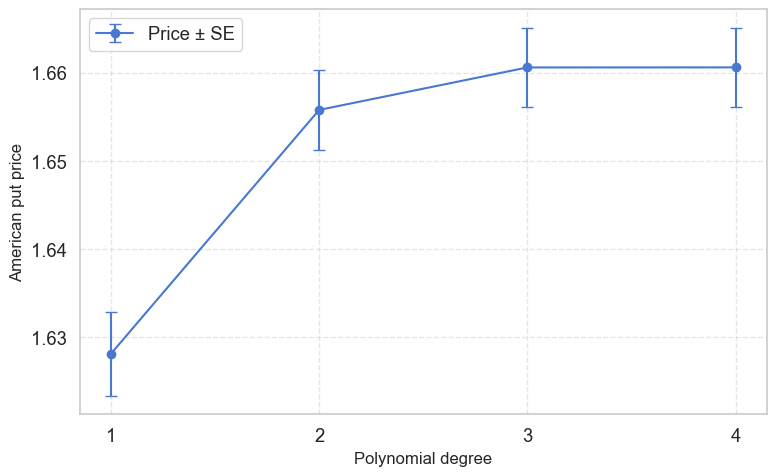

In [7]:
# Loop over each basis family
for basis_name, gen in basis_gens.items():
    print(f"\n=== Convergence tests using {basis_name} basis ===")

   
    basis3 = gen(n, 3)

    # 1) Time‐step convergence
    time_res = []
    for N_steps in [10, 25, 50, 100, 200]:
        step = N_steps_max // N_steps
        coarse = paths_max[:, ::step, :]
        dt = T / N_steps
        price, _ = lsm_price_nd(coarse, K, r, w, basis3, dt)
        time_res.append((N_steps, dt, price))

    # Plot
    _, dts, prices = zip(*time_res)

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(dts, prices,
            marker='o', linestyle='-',
            linewidth=1.5, markersize=6,
            label='Price')

    # Use a log‐scale on x, but with plain numeric labels
    ax.set_xscale('log')
    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.ticklabel_format(axis='x', style='plain')

    # Grid, labels, title
    ax.grid(True, which='both', linestyle='--', alpha=0.5)
    ax.set_xlabel(r'$\Delta t$ (years)', fontsize=12)
    ax.set_ylabel('American put price', fontsize=12)
    # ax.set_title(f'Time step Convergence ({basis_name})', fontsize=14)
    ax.legend()

    fig.tight_layout()
    plt.show()

    # 2) Monte Carlo convergence
    mc_res = []
    # reuse the same 50-step slicing:
    paths50 = paths_max[:, ::(N_steps_max//50), :]
    dt50 = T / 50
    for N in [10_000, 25_000, 50_000, 100_000, 200_000]:
        subset = paths50[:N]
        price, stderr = lsm_price_nd(subset, K, r, w, basis3, dt50)
        mc_res.append((N, price, stderr))

    # Plot
    Ns, Ps, Es = zip(*mc_res)

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.errorbar(Ns, Ps, yerr=Es,
            fmt='o-', capsize=4,
            linewidth=1.5, markersize=6,
            label='Price ± SE')

    # Log‐scale x with plain numeric labels
    ax.set_xscale('log')
    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.ticklabel_format(axis='x', style='plain')

    # Grid, labels, title
    ax.grid(True, which='both', linestyle='--', alpha=0.5)
    ax.set_xlabel('Number of paths', fontsize=12)
    ax.set_ylabel('American put price', fontsize=12)
    # ax.set_title(f'Monte Carlo Convergence ({basis_name})', fontsize=14)
    ax.legend()

    fig.tight_layout()
    plt.show()
    #3) Basis-degree convergence
    basis_res = []
    for degree in [1, 2, 3, 4]:
        basis_d = gen(n, degree)
        price, stderr = lsm_price_nd(paths50, K, r, w, basis_d, dt50)
        basis_res.append((degree, price, stderr))

    # Plot
    Ds, Ps2, Es2 = zip(*basis_res)

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.errorbar(Ds, Ps2, yerr=Es2,
            fmt='o-', capsize=4,
            linewidth=1.5, markersize=6,
            label='Price ± SE')

    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_xlabel('Polynomial degree', fontsize=12)
    ax.set_ylabel('American put price', fontsize=12)
    # ax.set_title(f'Basis Convergence ({basis_name})', fontsize=14)
    ax.set_xticks(Ds)   # ensure integer tick marks
    ax.legend()

    fig.tight_layout()
    plt.show()


In [8]:
# print(time_res)
# print(mc_res)
# print(basis_res)

# Neural Network

In order to tackle some of our efficiency problems with the rising number of approximations, we will try to incorporate a Neural Network, to see if this will better price the options. Both more accurately and faster. 

We run a setup equivalent to the extended LSM model, but we change the way, we approximate the continuation value. Instead of using regression, we replace it with a network. 

In [9]:
# === NN-LSM with Bengio-style training hygiene (fixed for NumPy<2, float weights) ===
import math, random, copy
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

# ---------- Utils ----------
def set_seed(seed: int = 42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)

class StdScalerX:
    """Column-wise standardizer for inputs X."""
    def __init__(self): self.mean_ = None; self.std_ = None
    def fit(self, X: np.ndarray):
        self.mean_ = X.mean(axis=0)
        self.std_  = X.std(axis=0)
        self.std_[self.std_ == 0.0] = 1.0
        return self
    def transform(self, X: np.ndarray) -> np.ndarray:
        return (X - self.mean_) / self.std_
    def inverse_transform(self, Xz: np.ndarray) -> np.ndarray:
        return Xz * self.std_ + self.mean_

class StdScalerY:
    """Scalar standardizer for targets y."""
    def __init__(self): self.mean_ = 0.0; self.std_ = 1.0
    def fit(self, y: np.ndarray):
        self.mean_ = float(np.mean(y))
        std = float(np.std(y))
        self.std_  = std if std > 0.0 else 1.0
        return self
    def transform(self, y: np.ndarray) -> np.ndarray:
        return (y - self.mean_) / self.std_
    def inverse(self, yz: np.ndarray) -> np.ndarray:
        return yz * self.std_ + self.mean_

# ---------- Model ----------
class MLP(nn.Module):
    def __init__(self, in_dim: int, hidden=(64, 64)):
        super().__init__()
        layers = []
        last = in_dim
        for h in hidden:
            layers += [nn.Linear(last, h), nn.ReLU()]  # <-- fjernet BatchNorm
            last = h
        layers += [nn.Linear(last, 1)]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x).squeeze(-1)


def _copy_weights(dst: nn.Module, src: nn.Module):
    """Warm-start: copy state dict if shapes match."""
    with torch.no_grad():
        dst.load_state_dict(copy.deepcopy(src.state_dict()))

# ---------- Training of one continuation model at time t ----------
def _fit_one_step(
    X_tr, y_tr, w_tr, X_val, y_val,
    prev_model: nn.Module | None,
    max_epochs=400, patience=20, lr=1e-3,
    weight_decay=1e-3, clip=1.0, device="cpu"
):
    """Train one MLP for continuation at a single time-step t."""
    Xsc = StdScalerX().fit(X_tr)
    Ysc = StdScalerY().fit(y_tr)

    Xtr = torch.tensor(Xsc.transform(X_tr), dtype=torch.float32, device=device)
    ytr = torch.tensor(Ysc.transform(y_tr), dtype=torch.float32, device=device)
    wtr = torch.tensor(w_tr.astype(np.float32), dtype=torch.float32, device=device)  # <-- FIXED

    Xva = torch.tensor(Xsc.transform(X_val), dtype=torch.float32, device=device)
    yva = torch.tensor(Ysc.transform(y_val), dtype=torch.float32, device=device)

    model = MLP(in_dim=Xtr.shape[1], hidden=(64, 64)).to(device)
    if prev_model is not None:
        try: _copy_weights(model, prev_model)  # warm-start from t+1
        except Exception: pass

    opt  = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    crit = nn.SmoothL1Loss(reduction='none')  # Huber

    best_state = copy.deepcopy(model.state_dict())
    best_val   = float('inf'); bad_epochs = 0

    batch_size = min(1024, Xtr.shape[0])
    n = Xtr.shape[0]
    idx = np.arange(n)

    for epoch in range(max_epochs):
        np.random.shuffle(idx)
        model.train()
        tr_loss = 0.0
        for s in range(0, n, batch_size):
            b = idx[s:s+batch_size]
            xb, yb, wb = Xtr[b], ytr[b], wtr[b]
            opt.zero_grad(set_to_none=True)
            pred = model(xb)
            loss_vec = crit(pred, yb)
            # weighted mean
            loss = (wb * loss_vec).sum() / (wb.sum() + 1e-8)
            loss.backward()
            if clip is not None:
                nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)
            opt.step()
            tr_loss += loss.item() * len(b)
        tr_loss /= n

        model.eval()
        with torch.no_grad():
            pv = model(Xva)
            val_loss = nn.MSELoss(reduction='mean')(pv, yva).item()

        if val_loss + 1e-8 < best_val:
            best_val = val_loss
            best_state = copy.deepcopy(model.state_dict())
            bad_epochs = 0
        else:
            bad_epochs += 1
            if bad_epochs >= patience:
                break

    model.load_state_dict(best_state)
    return model, Xsc, Ysc, best_val

# ---------- Full backward LSM training ----------
def train_nn_lsm(
    paths_nd: np.ndarray,  # (N_paths, N_steps+1, n_assets)
    w_vec: np.ndarray, r: float, K: float, T: float,
    *,
    margin_frac=0.02, near_weight=0.2,
    lr=1e-3, weight_decay=1e-3, patience=20, max_epochs=400,
    device="cpu", seed=42
):
    set_seed(seed)
    Np, Np1, d = paths_nd.shape
    N = Np1 - 1
    dt = T / N

    basket = paths_nd @ w_vec
    payoff_T = np.maximum(K - basket[:, N], 0.0)
    tau      = np.full(Np, N, dtype=int)
    cash_tau = payoff_T.copy()

    models_pack = [None] * (N + 1)
    prev_model_tplus1 = None

    for t in range(N-1, 0, -1):
        alive = tau > t
        if not np.any(alive):
            models_pack[t] = (None, None, None)
            prev_model_tplus1 = None
            continue

        St   = paths_nd[alive, t, :]
        Bt   = basket[alive, t]
        imm  = np.maximum(K - Bt, 0.0)
        y_target = np.exp(-r * (tau[alive] - t) * dt) * cash_tau[alive]

        itm_mask  = imm > 0.0
        near_mask = (~itm_mask) & (np.abs(K - Bt) <= margin_frac * K)

        sel = itm_mask | near_mask
        if not np.any(sel):
            models_pack[t] = (None, None, None)
            prev_model_tplus1 = None
            continue

        X = St[sel]
        Y = y_target[sel]
        W = np.ones_like(Y, dtype=np.float32)    # <-- FIXED (ensure float weights)
        W[near_mask[sel]] = float(near_weight)

        m = X.shape[0]
        idx = np.arange(m); np.random.shuffle(idx)
        k_val = max(1, int(0.1 * m))
        val_idx = idx[:k_val]
        tr_idx  = idx[k_val:]

        X_tr, y_tr, w_tr = X[tr_idx], Y[tr_idx], W[tr_idx]
        X_va, y_va       = X[val_idx], Y[val_idx]

        model_t, Xsc_t, Ysc_t, _ = _fit_one_step(
            X_tr, y_tr, w_tr, X_va, y_va,
            prev_model=prev_model_tplus1,
            max_epochs=max_epochs, patience=patience,
            lr=lr, weight_decay=weight_decay, clip=1.0, device=device
        )

        with torch.no_grad():
            Xa_alive = torch.tensor(Xsc_t.transform(St), dtype=torch.float32, device=device)
            cont_z   = model_t(Xa_alive).cpu().numpy()
            cont     = Ysc_t.inverse(cont_z)

        exercise = (imm >= cont) & (imm > 0.0)
        upd = np.where(alive)[0][exercise]
        tau[upd]      = t
        cash_tau[upd] = imm[exercise]

        models_pack[t] = (model_t.to('cpu'), Xsc_t, Ysc_t)
        prev_model_tplus1 = model_t

    return models_pack, tau, cash_tau, dt

def price_with_models(paths_nd: np.ndarray, w_vec: np.ndarray, r: float, K: float, T: float, models_pack):
    Np, Np1, d = paths_nd.shape
    N = Np1 - 1
    dt = T / N

    basket = paths_nd @ w_vec
    payoff_T = np.maximum(K - basket[:, N], 0.0)
    tau      = np.full(Np, N, dtype=int)
    cash_tau = payoff_T.copy()

    for t in range(N-1, 0, -1):
        pack = models_pack[t]
        if pack is None or pack[0] is None:
            continue
        model_t, Xsc_t, Ysc_t = pack

        alive = tau > t
        if not np.any(alive): continue

        St  = paths_nd[alive, t, :]
        Bt  = basket[alive, t]
        imm = np.maximum(K - Bt, 0.0)

        with torch.no_grad():
            Xa = torch.tensor(Xsc_t.transform(St), dtype=torch.float32)
            cont_z = model_t(Xa).cpu().numpy()
            cont   = Ysc_t.inverse(cont_z)

        exercise = (imm >= cont) & (imm > 0.0)
        upd = np.where(alive)[0][exercise]
        tau[upd]      = t
        cash_tau[upd] = imm[exercise]

    disc = np.exp(-r * tau * dt)
    price  = float(np.mean(disc * cash_tau))
    stderr = float(np.std(disc * cash_tau, ddof=1) / np.sqrt(Np))
    return price, stderr


In [10]:
# === Run NN-LSM with Double MC and compare to European price ===
# Assumes your simulate_gbm_nd and basket_put_price are already defined earlier.

# Problem setup (feel free to change)
n = 5
S0 = [40.0] * n
sigma = [0.2] * n
r = 0.06
T = 1.0
N_steps = 50
K = 40.0
w = np.array([1.0/n] * n)
rho = 0.2
R = np.full((n, n), rho); np.fill_diagonal(R, 1.0)

seed_train = 2025
seed_test  = 2026
N_paths_train = 100_000
N_paths_test  = 100_000

# Simulate independent train/test paths
paths_train = simulate_gbm_nd(S0, sigma, R, r, T, N_steps, N_paths_train, seed=seed_train)
paths_test  = simulate_gbm_nd(S0, sigma, R, r, T, N_steps, N_paths_test,  seed=seed_test)

# Train NN-LSM (backwards), Bengio-style training hygiene
models_pack, tau_train, cash_train, dt = train_nn_lsm(
    paths_train, w, r, K, T,
    margin_frac=0.02,     # include near-ITM states within 2% of K
    near_weight=0.2,      # give them smaller weight
    lr=1e-3, weight_decay=1e-3,
    patience=20, max_epochs=400,
    device="cpu", seed=42
)

# Double Monte Carlo price on independent test paths
nn_price, nn_stderr = price_with_models(paths_test, w, r, K, T, models_pack)

# European basket put (benchmark)
euro_price = basket_put_price(S0, K, r, sigma, rho, T, weights=w)

print(f"NN-LSM   : price = {nn_price:.6f} ± {nn_stderr:.6f}")
print(f"European (benchmark): price = {euro_price:.6f}")
if nn_price + 3*nn_stderr < euro_price:
    print("WARNING: NN price is (significantly) below European — check training data/scale/regularization.")


NN-LSM   : price = 1.141942 ± 0.004874
European (benchmark): price = 0.920518
